In [1]:
# Localhost
# http://localhost:4040/ 

Blah

import os
import sys
import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import to_date, col
from pyspark.sql.functions import when, lit, col
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql.functions import rank
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.types import StructType,StructField 
from pyspark.sql.types import StringType, IntegerType, ArrayType, DateType, DoubleType
from pyspark.sql.types import StringType, ArrayType, StructType, StructField

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Packages
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()

24/01/10 17:49:27 WARN Utils: Your hostname, Largo-MBP.local resolves to a loopback address: 127.0.0.1; using 172.20.10.9 instead (on interface en0)
24/01/10 17:49:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/10 17:49:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
##############################################################################
# LOAD DATA
##############################################################################
path='/Users/largo/Git/Ressources/data/translated_swiss_eb.csv'

customSchema = StructType([
    StructField("Year", StringType(), True),        
    StructField("Category", StringType(), True),
    StructField("Energy Carrier", StringType(), True),
    StructField("TJ", DoubleType(), True)
    ]
)
    
df = spark.read.csv(path, header=True, schema=customSchema)
df = df.toDF(*[c.lower() for c in df.columns])
new_columns = [(F.col(col_name).alias(col_name.replace(' ', '_'))) for col_name in df.columns]
# Use the unpacking operator (*) inside toDF to rename columns
df = df.select(*new_columns)
df.show()
df.printSchema


+----+--------------------+--------------------+--------+
|year|            category|      energy_carrier|      tj|
+----+--------------------+--------------------+--------+
|1980|   Gross consumption|         electricity|-29450.0|
|1980|   Gross consumption|           Petroleum|321250.0|
|1980|   Gross consumption|    District heating|     0.0|
|1980|   Gross consumption|                 gas| 36280.0|
|1980|   Gross consumption|         Wood energy| 26280.0|
|1980|   Gross consumption|           Core fuel|149050.0|
|1980|   Gross consumption|               Money| 14300.0|
|1980|   Gross consumption|Garbage and indus...| 10100.0|
|1980|   Gross consumption|           crude oil|191970.0|
|1980|   Gross consumption|Extendation of re...|    null|
|1980|   Gross consumption|          Hydropower|120750.0|
|1980|Self -consumption...|         electricity|-17020.0|
|1980|Self -consumption...|           Petroleum| -8330.0|
|1980|Self -consumption...|    District heating| -1000.0|
|1980|Self -co

<bound method DataFrame.printSchema of DataFrame[year: string, category: string, energy_carrier: string, tj: double]>

In [5]:
##############################################################################
# GENERAL INFORMATION 
##############################################################################
df.select(*(df.columns)).summary().show()
df.select("category").distinct().collect()
df.select("energy_carrier").distinct().collect()

24/01/10 17:50:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+-------------------+--------------+-----------------+
|summary|             year|           category|energy_carrier|               tj|
+-------+-----------------+-------------------+--------------+-----------------+
|  count|             8987|               8987|          8987|             4394|
|   mean|           2001.0|               null|          null|34238.76422394174|
| stddev|12.41036412720534|               null|          null|94415.58114712019|
|    min|             1980|Domestic production|     Core fuel|        -287670.0|
|    25%|           1990.0|               null|          null|              0.0|
|    50%|           2001.0|               null|          null|           3660.0|
|    75%|           2012.0|               null|          null|          39140.0|
|    max|             2022|             import|           gas|         523760.0|
+-------+-----------------+-------------------+--------------+-----------------+



[Row(energy_carrier='Petroleum'),
 Row(energy_carrier='gas'),
 Row(energy_carrier='Core fuel'),
 Row(energy_carrier='Money'),
 Row(energy_carrier='Wood energy'),
 Row(energy_carrier='crude oil'),
 Row(energy_carrier='Hydropower'),
 Row(energy_carrier='District heating'),
 Row(energy_carrier='electricity'),
 Row(energy_carrier='Extendation of renewable energies'),
 Row(energy_carrier='Garbage and industrial waste')]

In [6]:
df = df.withColumn("year_as_date", to_date(col("year"), "yyyy"))

time_series = df.filter(df.category=="Gross consumption").groupBy("year_as_date").agg({"tj": "sum"}).orderBy(["year_as_date"])
#time_series.printSchema
#time_series.show()
time_series.summary().show()


+-------+------------------+
|summary|           sum(tj)|
+-------+------------------+
|  count|                43|
|   mean|1054831.1627906978|
| stddev| 93758.40056862732|
|    min|          836080.0|
|    25%|         1003480.0|
|    50%|         1082850.0|
|    75%|         1130170.0|
|    max|         1181070.0|
+-------+------------------+



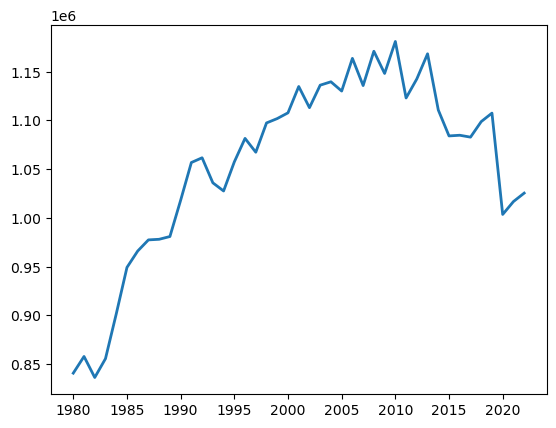

In [9]:
fig, ax = plt.subplots()

ax.plot(time_series.year_as_date, time_series['sum(tj)'], linewidth=2.0)

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

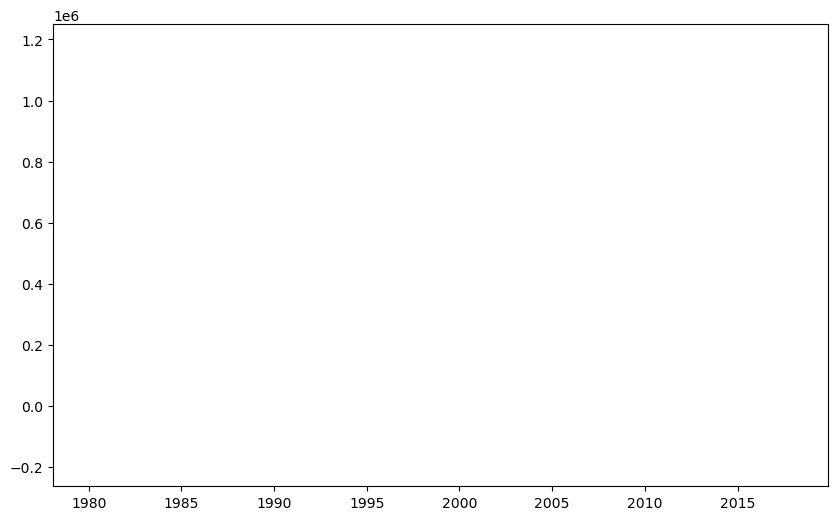

24/01/10 19:53:42 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 2031161 ms exceeds timeout 120000 ms
24/01/10 19:53:42 WARN SparkContext: Killing executors is not supported by current scheduler.
24/01/10 19:53:42 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at s

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
from pyspark.sql.functions import col, collect_list

multi_time_series = df.groupBy(["year", "category"]).agg({"tj": "sum"})

multi_time_series = multi_time_series.withColumn("year_as_date", to_date(col("year"), "yyyy"))

# Assuming you have a SparkSession named 'spark' and a PySpark DataFrame named 'df'
# Replace 'date_column' and 'value_column' with your actual column names
date_column = 'year'  # Example column name with dates
value_column = 'sum(tj)'  # Example column name with values

# Group the DataFrame by the series column and collect the data into lists
grouped_data = multi_time_series.groupBy(["year", 'category']).agg(collect_list(date_column).alias('dates'), collect_list(value_column).alias('values'))

# Convert the PySpark DataFrame to Pandas DataFrame for plotting
pandas_df = grouped_data.toPandas()

# Plotting multiple time series
plt.figure(figsize=(10, 6))
for i, row in pandas_df.iterrows():
    plt.plot(pd.to_datetime(row['dates']), row['values'], label=row['category'])

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Multiple Time Series Plot')
plt.legend()
plt.grid(True)
plt.show()

24/01/10 17:49:41 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+----+--------+---+
|year|category| tj|
+----+--------+---+
|2000|       A| 10|
|2000|       B| 20|
|2000|       C| 30|
|2000|       D| 40|
|2001|       A| 20|
|2001|       B| 40|
|2001|       C| 60|
|2001|       D| 80|
|2002|       A| 30|
|2002|       B| 60|
|2002|       C| 90|
|2002|       D|120|
+----+--------+---+

+----+--------+---+
|year|category| tj|
+----+--------+---+
|2000|       A| 10|
|2000|       B| 20|
|2000|       C| 30|
|2000|       D| 40|
|2001|       A| 20|
|2001|       B| 40|
|2001|       C| 60|
|2001|       D| 80|
|2002|       A| 30|
|2002|       B| 60|
|2002|       C| 90|
|2002|       D|120|
+----+--------+---+

+----------+--------+---+
|      year|category| tj|
+----------+--------+---+
|2000-01-01|       A| 10|
|2000-01-01|       B| 20|
|2000-01-01|       C| 30|
|2000-01-01|       D| 40|
|2001-01-01|       A| 20|
|2001-01-01|       B| 40|
|2001-01-01|       C| 60|
|2001-01-01|       D| 80|
|2002-01-01|       A| 30|
|2002-01-01|       B| 60|
|2002-01-01|       C

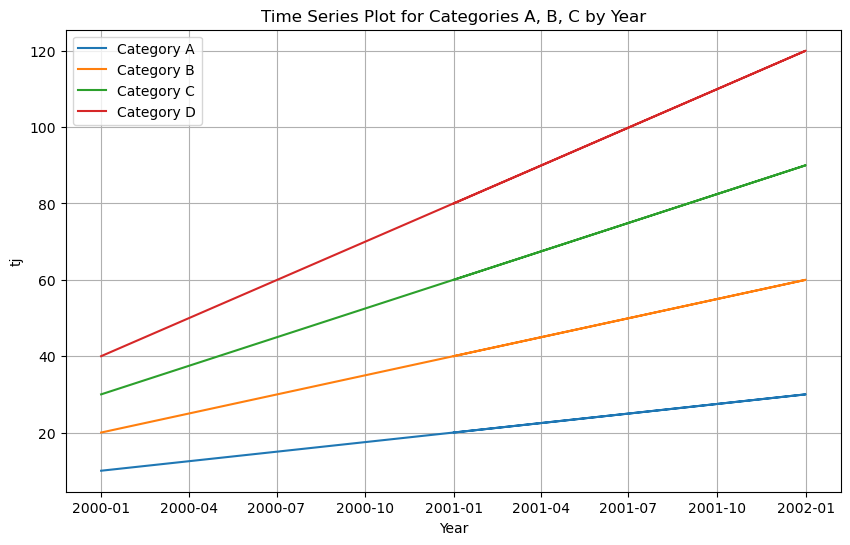

In [2]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# Sample data
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# Sample data
data = [
    (2000, 'A', 10),
    (2000, 'B', 20),
    (2000, 'C', 30),
    (2000, 'D', 40),
    (2001, 'A', 20),
    (2001, 'B', 40),
    (2001, 'C', 60),
    (2001, 'D', 80),
    (2002, 'A', 30),
    (2002, 'B', 60),
    (2002, 'C', 90),
    (2002, 'D', 120)
]

# Create a SparkSession
spark = SparkSession.builder.appName("TableGeneration").getOrCreate()

# Define the schema for the DataFrame
schema = StructType([
    StructField("year", IntegerType(), True),
    StructField("category", StringType(), True),
    StructField("tj", IntegerType(), True)
])

# Create a PySpark DataFrame
df = spark.createDataFrame(data, schema)

# Show the DataFrame as a table
df.show()


# Create a SparkSession
spark = SparkSession.builder.appName("TableGeneration").getOrCreate()

# Define the schema for the DataFrame
schema = StructType([
    StructField("year", IntegerType(), True),
    StructField("category", StringType(), True),
    StructField("tj", IntegerType(), True)
])

# Create a PySpark DataFrame
df = spark.createDataFrame(data, schema)

# Show the DataFrame as a table
df.show()



df = df.withColumn("year", to_date(col("year"), "yyyy"))
df.show()


# Filter the DataFrame for categories A, B, and C
filtered_df = df.filter(df['category'].isin(['A', 'B', 'C', 'D']))

# Pivot the DataFrame to create separate time series for each category
pivot_df = filtered_df.groupBy('year').pivot('category').sum('tj').fillna(0)

# Convert the pivoted DataFrame to Pandas for plotting
pandas_df = pivot_df.toPandas()

# Plotting the time series
plt.figure(figsize=(10, 6))
for category in ['A', 'B', 'C', 'D']:
    plt.plot(pandas_df['year'], pandas_df[category], label=f'Category {category}')

plt.xlabel('Year')
plt.ylabel('tj')
plt.title('Time Series Plot for Categories A, B, C by Year')
plt.legend()
plt.grid(True)
plt.show()

